# Dataset
In this homework, we'll build a model for predicting if we have an image of a dog or a cat. For this, we will use the "Dogs & Cats" dataset that can be downloaded from Kaggle.

You need to download the `train.zip` file.

If you have troubles downloading from Kaggle, use this link instead:

`wget https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats/train.zip`

In the lectures we saw how to use a pre-trained neural network. In the homework, we'll train a much smaller model from scratch.

>**Note**: You don't need a computer with a GPU for this homework. A laptop or any personal computer should be sufficient.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

! mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c dogs-vs-cats

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes
 99% 268M/271M [00:04<00:00, 86.9MB/s]
100% 271M/271M [00:04<00:00, 67.3MB/s]
100% 542M/543M [00:05<00:00, 76.6MB/s]
100% 543M/543M [00:05<00:00, 106MB/s] 
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 87.5MB/s]


# Data Preparation
The dataset contains 12,500 images of cats and 12,500 images of dogs.

Now we need to split this data into train and validation

Create a train and validation folders

In each folder, create cats and dogs folders

Move the first 10,000 images to the train folder (from 0 to 9999) for boths cats and dogs - and put them in respective folders

Move the remaining 2,500 images to the validation folder (from 10000 to 12499)
You can do this manually or with Python (check os and shutil packages).

In [ ]:
# unzip train dataset
!unzip -q '/content/train.zip'

In [ ]:
# command to remove folder
#!rm -rf '/content/test'
#!rm -rf '/content/train'

In [ ]:
# create folders for train part
!mkdir '/content/train/cats'
!mkdir '/content/train/dogs'

# move first 10000 images of cats and dogs to train folders
!bash -c 'mv /content/train/cat.{0..9999}.jpg /content/train/cats'
!bash -c 'mv /content/train/dog.{0..9999}.jpg /content/train/dogs'

In [ ]:
# create folders for test part
!mkdir '/content/test'
!mkdir '/content/test/cats'
!mkdir '/content/test/dogs'

# move remainders to test folders
!bash -c 'mv /content/train/cat.{10000..12499}.jpg /content/test/cats'
!bash -c 'mv /content/train/dog.{10000..12499}.jpg /content/test/dogs'

In [ ]:
#import os
#import shutil

#train_dir = '...'
#valid_dir = '...'

#fnames = ['cat.{}.jpg'.format(i) for i in range(10000)]
#for fname in fnames:
#    src = os.path.join(dataset_dir, fname)
#    dst = os.path.join(train_dir_cat, fname)
#    shutil.copyfile(src, dst)

# Model
For this homework we will use Convolutional Neural Network (CNN. Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a covolutional layer [`(Conv2D)`](https://keras.io/api/layers/convolution_layers/convolution2d/):
 * Use 32 filters
 * Kernel size should be `(3, 3)` (that's the size of the filter)
 * Use `'relu'` as activation
* Reduce the size of the feature map with max pooling [`(MaxPooling2D)`](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output
* As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:
        `SGD(lr=0.002, momentum=0.8)`

For clarification about kernel size and max pooling, check [Week #11 Office Hours](https://www.youtube.com/watch?v=1WRgdBTUaAc).

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Question 1
Since we have a binary classification problem, what is the best loss function for us?

**Answer**: `BinaryCrossentropy`

In [ ]:
def make_model():
    inputs = keras.Input(shape=(150, 150, 3))
    x = keras.layers.Conv2D(filters=32,
                            kernel_size=(3, 3),
                            activation='relu')(inputs)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.8)
    loss = keras.losses.BinaryCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [ ]:
model = make_model()

# Question 2
What's the total number of parameters of the model? You can use the `summary` method for that.

**Answer**: 11215873

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

# Generators and Training
For the next two questions, use the following data generator for both train and validation:

        `ImageDataGenerator(rescale=1./255)`
* We don't need to do any additional pre-processing for the images.

* Note: When reading the data from train/val directories, check the class_mode parameter. Which value should it be for a binary classification problem?

    **Answer:** `class_mode= 'binary'`

* Use `batch_size=20`

For training use `.fit()` with the following params:

        model.fit(
                 train_generator,
                 steps_per_epoch=100,
                 epochs=10,
                 validation_data=validation_generator,
                 validation_steps=50
        )

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    '/content/train/',
    target_size=(150, 150),
    classes= ['dogs', 'cats'],
    class_mode= 'binary',
    batch_size=20,
)

Found 20000 images belonging to 2 classes.


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

validation_generator = test_gen.flow_from_directory(
    '/content/test/',
    target_size=(150, 150),
    classes= ['dogs', 'cats'],
    class_mode= 'binary',
    batch_size=20,
    shuffle=False # this is a mistake! usually correct, but not in this homework
)

Found 5000 images belonging to 2 classes.


In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=100,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 8s 80ms/step - loss: 0.6932 - accuracy: 0.4770 - val_loss: 0.7812 - val_accuracy: 0.9990
Epoch 2/10
100/100 [==============================] - 8s 77ms/step - loss: 0.6886 - accuracy: 0.4870 - val_loss: 0.6978 - val_accuracy: 0.9660
Epoch 3/10
100/100 [==============================] - 8s 76ms/step - loss: 0.6851 - accuracy: 0.5175 - val_loss: 0.6293 - val_accuracy: 0.9950
Epoch 4/10
100/100 [==============================] - 8s 77ms/step - loss: 0.6736 - accuracy: 0.5190 - val_loss: 0.7051 - val_accuracy: 0.8760
Epoch 5/10
100/100 [==============================] - 8s 78ms/step - loss: 0.6761 - accuracy: 0.5360 - val_loss: 0.6266 - val_accuracy: 0.9850
Epoch 6/10
100/100 [==============================] - 8s 77ms/step - loss: 0.6581 - accuracy: 0.5610 - val_loss: 0.5790 - val_accuracy: 0.9540
Epoch 7/10
100/100 [==============================] - 8s 78ms/step - loss: 0.6586 - accuracy: 0.5525 - val_loss: 0.6913 - val_accuracy: 0.9010

# Question 3
What is the median of training accuracy for this model?

In [ ]:
np.median(history.history['accuracy'])

0.5442500114440918

# Question 4
What is the standard deviation of training loss for this model?

In [ ]:
np.std(history.history['loss'])

0.01698595882829454

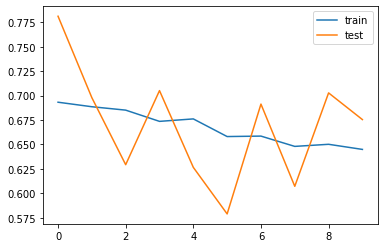

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

# Data Augmentation
For the next two questions, we'll generate more data using data augmentations.

Add the following augmentations to your training data generator:

        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'

In [ ]:
train_gen = ImageDataGenerator(
                               rescale=1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest'
)

train_generator = train_gen.flow_from_directory(
    '/content/train/',
    target_size=(150, 150),
    classes= ['dogs', 'cats'],
    class_mode= 'binary',
    batch_size=20,
)



Found 20000 images belonging to 2 classes.


# Question 5
Let's train our model for 10 more epochs using the same code as previously. Make sure you don't re-create the model - we want to continue training the model we already started training.

What is the mean of validation loss for the model trained with augmentations?

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=100,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 16s 159ms/step - loss: 0.6682 - accuracy: 0.5455 - val_loss: 0.6342 - val_accuracy: 0.9140
Epoch 2/10
100/100 [==============================] - 16s 158ms/step - loss: 0.6647 - accuracy: 0.5360 - val_loss: 0.7663 - val_accuracy: 0.7470
Epoch 3/10
100/100 [==============================] - 16s 160ms/step - loss: 0.6696 - accuracy: 0.5280 - val_loss: 0.6431 - val_accuracy: 0.9490
Epoch 4/10
100/100 [==============================] - 16s 159ms/step - loss: 0.6693 - accuracy: 0.5410 - val_loss: 0.6961 - val_accuracy: 0.9250
Epoch 5/10
100/100 [==============================] - 16s 158ms/step - loss: 0.6661 - accuracy: 0.5400 - val_loss: 0.6047 - val_accuracy: 0.9790
Epoch 6/10
100/100 [==============================] - 16s 160ms/step - loss: 0.6741 - accuracy: 0.5390 - val_loss: 0.6439 - val_accuracy: 0.9740
Epoch 7/10
100/100 [==============================] - 16s 161ms/step - loss: 0.6726 - accuracy: 0.5370 - val_loss: 0.6290 - val_ac

In [ ]:
np.mean(history.history['val_loss'])

0.6506128370761871

# Question 6
What's the average of validation accuracy for the last 5 epochs (from 6 to 10) for the model trained with augmentations?

In [ ]:
np.mean(history.history['val_accuracy'][-5:])

0.9669999957084656

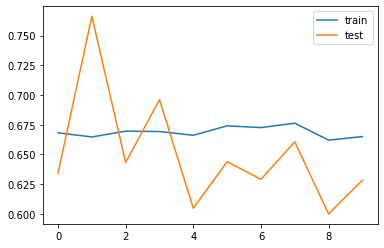

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

<blockquote class="twitter-tweet"><p lang="en" dir="ltr"><a href="https://twitter.com/hashtag/MLZoomcamp?src=hash&amp;ref_src=twsrc%5Etfw">#MLZoomcamp</a> Back to homeworks after midterm project! Now it&#39;s about Deep Learning using Keras.</p>&mdash; sha of smile (@trueRock_n_roll) <a href="https://twitter.com/trueRock_n_roll/status/1460925945406103552?ref_src=twsrc%5Etfw">November 17, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>